In [121]:
# Set to True to export results
params_export_flag = True

# Set to true to include timestamp in output directory name
# TODO: actually a bad idea as data dependencies between notebooks rely on stable paths.
params_export_timestamp = False

# String for a filepath to a config file mapping file identifiers to filepaths.
input_config_filepaths = None

# Parent directory for output files
output_directory = "../results/"

# Figure - Comparative genomics - mouse / human gene sets orthologies from annotations of binding sites

## Overview

Venn diagram to show the species-specific and orthologously bound genes in human and mouse.

## Imports

In [25]:
import datetime
import importlib
import os
import sys
from pathlib import Path
import pandera

from numbers import Number
from typing import Sequence, List, Set, Union, Tuple, Optional

import itertools as itt
import functools

import numpy as np
import pandas as pd
import yaml

import pybedtools as pbt
import pyBigWig as pbw

import scipy.stats
import statsmodels.stats.multitest
from dotmap import DotMap

import matplotlib as mpl

from dotenv import load_dotenv, find_dotenv

In [93]:
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from matplotlib import rc
import matplotlib_venn as venn
import matplotlib_inline

try:
    matplotlib.font_manager.findfont("Arial")
    mpl.rcParams["font.sans-serif"] = ["Arial"]
except Exception as e:
    print(f"Arial font not found: {e}")
    mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]

rc("text", usetex=False)


FONT_SMALL_SIZE = 16
FONT_MEDIUM_SIZE = 20
FONT_BIGGER_SIZE = 22

mpl.rc("font", size=FONT_SMALL_SIZE)  # controls default text sizes
mpl.rc("axes", titlesize=FONT_SMALL_SIZE)  # fontsize of the axes title
mpl.rc("axes", labelsize=FONT_MEDIUM_SIZE)  # fontsize of the x and y labels
mpl.rc("xtick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("ytick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("legend", fontsize=FONT_SMALL_SIZE)  # legend fontsize
mpl.rc("figure", titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

DEFAULT_FIGSIZE = (10, 6)
plt.rcParams["figure.figsize"] = DEFAULT_FIGSIZE
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = FONT_SMALL_SIZE
plt.rcParams["figure.titlesize"] = FONT_BIGGER_SIZE
plt.rcParams["xtick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["ytick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["axes.axisbelow"] = True

## Initialization

In [122]:
if params_export_flag:
    if params_export_timestamp:
        timestamp_format = "%Y-%m-%d"

        outputdir = Path(output_directory) / f"gene_sets_overlaps.{datetime.datetime.now().strftime(timestamp_format)}"

    else:
        outputdir = Path(output_directory) / "gene_sets_overlaps"

    if not outputdir.exists():
        outputdir.mkdir(parents=True)

    print(outputdir)

../results/gene_sets_overlaps


In [12]:
if input_config_filepaths is not None:
    if Path(input_config_filepaths).exists():
        with open(input_config_filepaths, "r") as f:
            filepaths = yaml.safe_load(f)
    else:
        filepaths = {}

# NOTE: hard-coded filepaths override config filepaths if defined
local_filepaths = {
    "supp_table_binding_sites": None,
    "mouse_3utr_bs_mappability": None,
    "human_3utr_bs_mappability": None,
}

filepaths = {
    **{k: v for k, v in local_filepaths.items() if v is not None},
    **filepaths,
}

In [24]:
FONT_SMALL_SIZE = 16
FONT_MEDIUM_SIZE = 20
FONT_BIGGER_SIZE = 22

mpl.rc("font", size=FONT_SMALL_SIZE)  # controls default text sizes
mpl.rc("axes", titlesize=FONT_SMALL_SIZE)  # fontsize of the axes title
mpl.rc("axes", labelsize=FONT_MEDIUM_SIZE)  # fontsize of the x and y labels
mpl.rc("xtick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("ytick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("legend", fontsize=FONT_SMALL_SIZE)  # legend fontsize
mpl.rc("figure", titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = FONT_SMALL_SIZE
plt.rcParams["figure.titlesize"] = FONT_BIGGER_SIZE
plt.rcParams["xtick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["ytick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["axes.axisbelow"] = True

## Definitions

In [17]:
def has_array_one_value_greater_than_others(arr: Sequence[Number]) -> bool:
    if len(arr) == 0:
        raise ValueError("Empty array")

    if len(arr) == 1:
        return True

    else:
        arr_s = sorted(arr, reverse=True)
        if arr_s[0] > arr_s[1]:
            return True
        else:
            return False


def build_identifier_bed6(row_bed6: pd.Series) -> str:
    """Build a sequence identifier as {chrom}:{start}-{end}:{strand} from BED6 row."""
    return row_bed6["chrom"] + ":" + str(row_bed6["start"]) + "-" + str(row_bed6["end"]) + ":" + row_bed6["strand"]


def series_extract_set_annotation(column: pd.Series) -> list[set[str]]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .map(lambda v: list(map(lambda elem: elem.split(";")[0], v)))
        .map(set)
    ).tolist()
    return list_extracted_annotations


def series_extract_first_annotation(column: pd.Series) -> list[str]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters).str.split(";;").str[0].str.split(";").str[0]
    ).tolist()
    return list_extracted_annotations


def series_extract_first_gene_id(column: pd.Series) -> list[str]:
    expected_format_delimiters = ";NULL.NULL;;NULL"
    list_extracted_ids = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .str[0]
        .str.split(";")
        .str[-1]
        .str.split(".")
        .str[0]
    ).tolist()
    return list_extracted_ids


def series_extract_set_geneid(column: pd.Series) -> list[set[str]]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .map(lambda v: list(map(lambda elem: elem.split(";")[-1].split(".")[0], v)))
        .map(set)
    ).tolist()
    return list_extracted_annotations


def complete_bed6_table_with_additional_columns(df: pd.DataFrame) -> pd.DataFrame:
    df["identifier"] = df.apply(lambda row: build_identifier_bed6(row), axis=1)
    df["gene_id"] = series_extract_first_gene_id(df["name"])
    df["main_annot"] = series_extract_first_annotation(df["name"])
    df["annot_set"] = series_extract_set_annotation(df["name"])
    df["gene_id_set"] = series_extract_set_geneid(df["name"])

    return df


def load_bed6_table_and_complete_with_additional_columns(path: os.PathLike, columns: list[str]) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        header=None,
        index_col=None,
        sep="\t",
        names=columns,
        comment="#",
    )

    df = complete_bed6_table_with_additional_columns(df)

    return df

In [ ]:
def check_mouse_orthologies_first_order(
    mouse_identifier: str,
    human_identifier: str,
    m_id_to_meta: pd.DataFrame,
    h_id_to_meta: pd.DataFrame,
    m_orth_sets: dict[str, set[str]],
) -> Optional[bool]:
    """Check whether the "best" gene ID of the source mouse peak is orthologous to the "best" gene ID from its lifted coordinates."""
    m_gene_id = m_id_to_meta.loc[mouse_identifier]["gene_id"]
    h_gene_id = h_id_to_meta.loc[human_identifier]["gene_id"]

    if m_gene_id in m_orth_sets:
        if h_gene_id in m_orth_sets[m_gene_id]:
            return True
        else:
            return False
    else:
        return None


def check_mouse_orthologies_second_order(
    mouse_identifier: str,
    human_identifier: str,
    m_id_to_meta: pd.DataFrame,
    h_id_to_meta: pd.DataFrame,
    m_orth_sets: dict[str, set[str]],
) -> Optional[bool]:
    """Check whether the "best" gene ID of the source mouse peak is orthologous to any of the gene IDs from its lifted coordinates."""
    m_gene_id = m_id_to_meta.loc[mouse_identifier]["gene_id"]
    h_gene_id_set = h_id_to_meta.loc[human_identifier]["gene_id_set"]

    if m_gene_id in m_orth_sets:
        for h_gene_id in h_gene_id_set:
            if h_gene_id in m_orth_sets[m_gene_id]:
                return True
        else:
            return False
    else:
        return None


def check_mouse_orthologies_third_order(
    mouse_identifier: str,
    human_identifier: str,
    m_id_to_meta: pd.DataFrame,
    h_id_to_meta: pd.DataFrame,
    m_orth_sets: dict[str, set[str]],
) -> list[tuple[str, Union[list[str], bool, None]]]:
    """Check whether any  gene ID of the source mouse peak is orthologous to any of the gene IDs from its lifted coordinates.

    NOTE: Here the return structure is a bit more elaborated,
    as it return all the instances of mouse gene IDs along
    with either:

    - a string for one of the human gene IDs (found as ortholog)
    - or False (if none of the human gene IDs are orthologous)
    - or np.nan (if the mouse gene ID is not found in the orthologs table).

    """
    m_gene_id_set = m_id_to_meta.loc[mouse_identifier]["gene_id_set"] - set(
        "",
    )
    h_gene_id_set = h_id_to_meta.loc[human_identifier]["gene_id_set"] - set(
        "",
    )

    return_list = []
    for m_gene_id in m_gene_id_set:
        if m_gene_id in m_orth_sets:
            orths = m_orth_sets[m_gene_id]

            if orths & h_gene_id_set:
                return_list.append((m_gene_id, list(orths & h_gene_id_set)))
            else:
                return_list.append((m_gene_id, False))

        else:
            return_list.append((m_gene_id, None))

    return return_list


####


def check_human_orthologies_first_order(
    human_identifier: str,
    mouse_identifier: str,
    h_id_to_meta: pd.DataFrame,
    m_id_to_meta: pd.DataFrame,
    h_orth_sets: dict[str, set[str]],
) -> Optional[bool]:
    """Check whether the "best" gene ID of the source human peak is orthologous to the "best" gene ID from its lifted coordinates."""
    h_gene_id = h_id_to_meta.loc[human_identifier]["gene_id"]
    m_gene_id = m_id_to_meta.loc[mouse_identifier]["gene_id"]

    if h_gene_id in h_orth_sets:
        if m_gene_id in h_orth_sets[h_gene_id]:
            return True
        else:
            return False
    else:
        return None


def check_human_orthologies_second_order(
    human_identifier: str,
    mouse_identifier: str,
    h_id_to_meta: pd.DataFrame,
    m_id_to_meta: pd.DataFrame,
    h_orth_sets: dict[str, set[str]],
) -> Optional[bool]:
    """Check whether the "best" gene ID of the source human peak is orthologous to any of the gene IDs from its lifted coordinates."""
    h_gene_id = h_id_to_meta.loc[human_identifier]["gene_id"]
    m_gene_id_set = m_id_to_meta.loc[mouse_identifier]["gene_id_set"]

    if h_gene_id in h_orth_sets:
        for m_gene_id in m_gene_id_set:
            if m_gene_id in h_orth_sets[h_gene_id]:
                return True
        else:
            return False
    else:
        return None


def check_human_orthologies_third_order(
    human_identifier: str,
    mouse_identifier: str,
    h_id_to_meta: pd.DataFrame,
    m_id_to_meta: pd.DataFrame,
    h_orth_sets: dict[str, set[str]],
) -> list[tuple[str, Union[list[str], bool, None]]]:
    """Check whether any  gene ID of the source mouse peak is orthologous to any of the gene IDs from its lifted coordinates.

    NOTE: Here the return structure is a bit more elaborated,
    as it return all the instances of mouse gene IDs along
    with either:

    - a string for one of the human gene IDs (found as ortholog)
    - or False (if none of the human gene IDs are orthologous)
    - or np.nan (if the mouse gene ID is not found in the orthologs table).
    """
    m_gene_id_set = m_id_to_meta.loc[mouse_identifier]["gene_id_set"] - set(
        "",
    )
    h_gene_id_set = h_id_to_meta.loc[human_identifier]["gene_id_set"] - set(
        "",
    )

    return_list = []
    for h_gene_id in h_gene_id_set:
        if h_gene_id in h_orth_sets:
            orths = h_orth_sets[h_gene_id]

            if orths & m_gene_id_set:
                return_list.append((h_gene_id, list(orths & m_gene_id_set)))
            else:
                return_list.append((h_gene_id, False))

        else:
            return_list.append((h_gene_id, None))

    return return_list


####


def flag_from_third_order_orthologies(
    orthologies: list[tuple[str, Union[list[str], bool, None]]],
) -> bool:
    """Flag the orthologies from the third order orthologies."""
    as_bool_or_none_associated_values = []

    for gene_id, ortho in orthologies:
        if isinstance(ortho, list):
            as_bool_or_none_associated_values.append(True)

        elif isinstance(ortho, bool) and not ortho:
            as_bool_or_none_associated_values.append(False)

        else:
            as_bool_or_none_associated_values.append(None)

    if any(as_bool_or_none_associated_values):
        return True

    else:
        if all([v is None for v in as_bool_or_none_associated_values]):
            return None
        else:
            return False

## Initialization

In [19]:
bed6_cols = ["chrom", "start", "end", "name", "score", "strand"]

In [21]:
if params_export_flag:
    if params_export_timestamp:
        timestamp_format = "%Y-%m-%d"

        outputdir = Path(output_directory) / f"gene_sets_overlaps.{datetime.datetime.now().strftime(timestamp_format)}"
    else:
        outputdir = Path(output_directory) / "gene_sets_overlaps"

    if not outputdir.exists():
        outputdir.mkdir(parents=True)

    print(outputdir)

In [36]:
if input_config_filepaths is not None:
    if Path(input_config_filepaths).exists():
        with open(input_config_filepaths, "r") as f:
            filepaths = yaml.safe_load(f)
    else:
        filepaths = {}

# NOTE: hard-coded filepaths override config filepaths if defined
local_filepaths = {
    "mouse_chromsizes": "../../../roquin_lmoyon/general_storage/ucsc/chromsizes/mm10.chrom.sizes",
    "human_chromsizes": "../../../roquin_lmoyon/general_storage/ucsc/chromsizes/hg38.chrom.sizes",
    "orthologs": "../../../roquin_lmoyon/roquin_storage/orthologs/merged.human_mouse.tsv.gz",
    #
    "mouse_peaks_full": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/bs_mouse.bed",
    "mouse_peaks_mappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/bs_mouse_mappable.bed",
    "mouse_peaks_unmappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/unmapped_bs.txt",
    "mouse_peaks_lifted": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/lifted_mm_to_hg.bed",
    #
    "human_peaks_full": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/bs_human.bed",
    "human_peaks_mappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/bs_human_mappable.bed",
    "human_peaks_unmappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/unmapped_bs.txt",
    "human_peaks_lifted": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/lifted_hg_to_mm.bed",
    #
    #
}

filepaths = {
    **{k: v for k, v in local_filepaths.items() if v is not None},
    **local_filepaths,
}

## Load

In [20]:
DATA = DotMap()

### Misc

In [28]:
fp = filepaths["mouse_chromsizes"]
DATA["mouse"]["chromsizes_fp"] = fp
DATA["mouse"]["chromsizes"] = pd.read_csv(fp, sep="\t", header=None).set_index(0)[1].to_dict()

fp = filepaths["human_chromsizes"]
DATA["human"]["chromsizes_fp"] = fp
DATA["human"]["chromsizes"] = pd.read_csv(fp, sep="\t", header=None).set_index(0)[1].to_dict()

In [32]:
# Table of orthologous genes
fp = filepaths["orthologs"]
df = pd.read_csv(
    fp,
    header=0,
    index_col=None,
    sep="\t",
)


display(df.head(3))
display(df.shape)

DATA["orthologs"] = df

,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
0,ENSG00000000003,TSPAN6,ENSMUSG00000067377,Tspan6,1:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...
1,ENSG00000000005,TNMD,ENSMUSG00000031250,Tnmd,1:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...
2,ENSG00000000419,DPM1,ENSMUSG00000078919,Dpm1,n:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...


(32490, 8)

### Mouse peaks

In [34]:
print("MOUSE PEAKS")

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["mouse_peaks_full"], columns=bed6_cols)

print(f"Number of peaks in the 'full set': {df.shape[0]:,}")
DATA["mouse"]["peaks"]["full"] = df


####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["mouse_peaks_mappable"],  # NOTE: content is the same as mouse_bs_mapped.bed
    columns=bed6_cols,
)
print(f"Number of peaks in the 'mappable' set: {df.shape[0]:,}")
DATA["mouse"]["peaks"]["mappable"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["mouse_peaks_unmappable"], columns=bed6_cols)

print(f"Number of peaks in the 'unmapped' set: {df.shape[0]:,}")
DATA["mouse"]["peaks"]["unmapped"] = df

####


df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["mouse_peaks_lifted"],
    columns=bed6_cols + ["source_identifier"],
)

DATA["mouse"]["peaks"]["lifted"] = df
print(f"Number of peaks in the 'lifted' set: {df.shape[0]:,}")

MOUSE PEAKS
Number of peaks in the 'full set': 19,759
Number of peaks in the 'mappable' set: 17,426
Number of peaks in the 'unmapped' set: 2,333
Number of peaks in the 'lifted' set: 17,426


### Human peaks

In [37]:
print("HUMAN PEAKS")

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["human_peaks_full"], columns=bed6_cols)

print(f"Number of peaks in the 'full' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["full"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["human_peaks_mappable"],  # Same as human_bs_mapped.bed
    columns=bed6_cols,
)

print(f"Number of peaks in the 'mappable' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["mappable"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["human_peaks_unmappable"], columns=bed6_cols)

print(f"Number of peaks in the 'unmapped' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["unmapped"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["human_peaks_lifted"],
    columns=bed6_cols + ["source_identifier"],
)

print(f"Number of peaks in the 'lifted' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["lifted"] = df

HUMAN PEAKS
Number of peaks in the 'full' set: 33,492
Number of peaks in the 'mappable' set: 29,383
Number of peaks in the 'unmapped' set: 4,109
Number of peaks in the 'lifted' set: 29,383


### Verifications

In [ ]:
# Verifications :
# - regions should be unique
# - mappable + unmappable = full

m_full = DATA.mouse.peaks.full.loc[:, ["identifier", "name", "gene_id"]].copy()
m_map = DATA.mouse.peaks.mappable.loc[:, ["identifier", "name", "gene_id"]].copy()
m_umap = DATA.mouse.peaks.unmapped.loc[:, ["identifier", "name", "gene_id"]].copy()

assert m_full["identifier"].duplicated().sum() == 0
assert m_map["identifier"].duplicated().sum() == 0
assert m_umap["identifier"].duplicated().sum() == 0
assert set(m_map["identifier"].unique()) | set(m_umap["identifier"].unique()) == set(m_full["identifier"].unique())


h_full = DATA.human.peaks.full.loc[:, ["identifier", "name", "gene_id"]].copy()
h_map = DATA.human.peaks.mappable.loc[:, ["identifier", "name", "gene_id"]].copy()
h_umap = DATA.human.peaks.unmapped.loc[:, ["identifier", "name", "gene_id"]].copy()

assert h_full["identifier"].duplicated().sum() == 0
assert h_map["identifier"].duplicated().sum() == 0
assert h_umap["identifier"].duplicated().sum() == 0
assert set(h_map["identifier"].unique()) | set(h_umap["identifier"].unique()) == set(h_full["identifier"].unique())

## Orthologies - any biotype

- We have assembled a table of mouse-human orthologous genes from multiple resources.
- We have lifted-over peaks from mouse to human genome and vice versa.
- We can establish the types of orthologies from lifted peaks establishing the orthology between the source and lifted annotation (orthologous gene or not, same biotype or not, etc.)

### Gather tables

In [48]:
m_id_to_meta = (
    pd.concat(
        [
            DATA.mouse.peaks.full.loc[
                :, ["identifier", "name", "gene_id", "main_annot", "annot_set", "gene_id_set"]
            ].copy(),
            DATA.human.peaks.lifted.loc[
                :, ["identifier", "name", "gene_id", "main_annot", "annot_set", "gene_id_set"]
            ].copy(),
        ],
        axis=0,
    )
    .drop_duplicates(subset="identifier")
    .set_index("identifier")
)

display(f"{m_id_to_meta.shape=}")
display(m_id_to_meta.head(3))

m_id_to_bed6 = (
    pd.concat(
        [
            DATA.mouse.peaks.full.loc[:, bed6_cols + ["identifier"]],
            DATA.human.peaks.lifted.loc[:, bed6_cols + ["identifier"]],
        ],
        axis=0,
    )
    .drop_duplicates()
    .set_index("identifier")
)

display(f"{m_id_to_bed6.shape=}")
display(m_id_to_bed6.head(3))

m_lift = (
    DATA.mouse.peaks.lifted.loc[:, ["source_identifier", "identifier"]]
    .copy()
    .rename(columns={"source_identifier": "identifier.mouse_source", "identifier": "identifier.human_target"})
)
display(f"{m_lift.shape=}")
display(m_lift.head(3))

'm_id_to_meta.shape=(48126, 5)'

,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000025907}
chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}
chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}


'm_id_to_bed6.shape=(49141, 6)'

,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:6274997-6275006:+,chr1,6274997,6275006,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,9.344450,+
chr1:7170406-7170415:+,chr1,7170406,7170415,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,5.094060,+
chr1:7170431-7170440:+,chr1,7170431,7170440,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,26.054101,+


'm_lift.shape=(17426, 2)'

,identifier.mouse_source,identifier.human_target
0,chr1:6274997-6275006:+,chr8:52623049-52623059:-
1,chr1:7170406-7170415:+,chr8:51819766-51819775:-
2,chr1:7170431-7170440:+,chr8:51819741-51819750:-


In [49]:
h_id_to_meta = (
    pd.concat(
        [
            DATA.human.peaks.full.loc[
                :, ["identifier", "name", "gene_id", "main_annot", "annot_set", "gene_id_set"]
            ].copy(),
            DATA.mouse.peaks.lifted.loc[
                :, ["identifier", "name", "gene_id", "main_annot", "annot_set", "gene_id_set"]
            ].copy(),
        ],
        axis=0,
    )
    .drop_duplicates(subset="identifier")
    .set_index("identifier")
)


display(f"{h_id_to_meta.shape=}")
display(h_id_to_meta.head(3))

h_id_to_bed6 = (
    pd.concat(
        [
            DATA.human.peaks.full.loc[:, bed6_cols + ["identifier"]],
            DATA.mouse.peaks.lifted.loc[:, bed6_cols + ["identifier"]],
        ],
        axis=0,
    )
    .drop_duplicates()
    .set_index("identifier")
)

display(f"{h_id_to_bed6.shape=}")
display(h_id_to_bed6.head(3))

h_lift = (
    DATA.human.peaks.lifted.loc[:, ["source_identifier", "identifier"]]
    .copy()
    .rename(columns={"source_identifier": "identifier.human_source", "identifier": "identifier.mouse_target"})
)

display(f"{h_lift.shape=}")
display(h_lift.head(3))

'h_id_to_meta.shape=(49904, 5)'

,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}


'h_id_to_bed6.shape=(50917, 6)'

,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:1211398-1211407:-,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-
chr1:1211415-1211424:-,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-
chr1:1211431-1211440:-,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-


'h_lift.shape=(29383, 2)'

,identifier.human_source,identifier.mouse_target
0,chr1:1211398-1211407:-,chr4:156016532-156016539:+
1,chr1:1211415-1211424:-,chr4:156016517-156016524:+
2,chr1:1211431-1211440:-,chr4:156016501-156016510:+


### Demo

In [ ]:
# Here : example of Rc3h1 (Roquin) with two close-by peaks in each species.

display(m_lift.loc[lambda df: df["identifier.mouse_source"] == "chr1:160973494-160973503:+", :])
display(h_lift.loc[lambda df: df["identifier.human_source"] == "chr1:173932765-173932774:-"])

display(
    m_id_to_meta.loc[
        [
            "chr1:160973494-160973503:+",
            "chr1:160973516-160973527:+",
        ],
        :,
    ]
)

,identifier.mouse_source,identifier.human_target
14339,chr1:160973494-160973503:+,chr1:173932787-173932789:-


,identifier.human_source,identifier.mouse_target
1840,chr1:173932765-173932774:-,chr1:160973516-160973527:+


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:160973494-160973503:+,three_prime_UTR;Rc3h1;protein_coding;ENSMUSG00...,ENSMUSG00000040423,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000040423}
chr1:160973516-160973527:+,three_prime_UTR;Rc3h1;protein_coding;ENSMUSG00...,ENSMUSG00000040423,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000040423}


In [ ]:
# Some peaks have multiple possible gene IDs.

display(h_id_to_meta["gene_id_set"].apply(len).value_counts())
display(h_id_to_meta.loc[lambda df: df["gene_id_set"].apply(len) > 1, :].head(5))


display(m_id_to_meta["gene_id_set"].apply(len).value_counts())
display(m_id_to_meta.loc[lambda df: df["gene_id_set"].apply(len) > 1, :].head(5))

1    49730
2      174
Name: gene_id_set, dtype: int64

,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr5:131462001-131462010:-,CDS;ENSG00000273217;protein_coding;ENSG0000027...,ENSG00000273217,CDS,{CDS},"{ENSG00000158987, ENSG00000273217}"
chr5:131427093-131427102:-,three_prime_UTR;ENSG00000273217;protein_coding...,ENSG00000273217,three_prime_UTR,{three_prime_UTR},"{ENSG00000158987, ENSG00000273217}"
chr5:131427067-131427076:-,three_prime_UTR;ENSG00000273217;protein_coding...,ENSG00000273217,three_prime_UTR,{three_prime_UTR},"{ENSG00000158987, ENSG00000273217}"
chr5:131426963-131426972:-,three_prime_UTR;ENSG00000273217;protein_coding...,ENSG00000273217,three_prime_UTR,{three_prime_UTR},"{ENSG00000158987, ENSG00000273217}"
chr5:131426926-131426935:-,three_prime_UTR;ENSG00000273217;protein_coding...,ENSG00000273217,three_prime_UTR,{three_prime_UTR},"{ENSG00000158987, ENSG00000273217}"


1    47988
2      138
Name: gene_id_set, dtype: int64

,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr4:151056815-151056821:-,intron;Camta1;protein_coding;ENSMUSG0000001459...,ENSMUSG00000014592,intron,{intron},"{ENSMUSG00000028955, ENSMUSG00000014592}"
chr3:90605025-90605034:+,CDS;Gm42674;protein_coding;ENSMUSG00000105518....,ENSMUSG00000105518,CDS,{CDS},"{ENSMUSG00000001020, ENSMUSG00000105518}"
chr3:90056248-90056257:+,CDS;4933434E20Rik;protein_coding;ENSMUSG000000...,ENSMUSG00000027942,CDS,{CDS},"{ENSMUSG00000027942, ENSMUSG00000118504}"
chr3:90056222-90056231:+,CDS;4933434E20Rik;protein_coding;ENSMUSG000000...,ENSMUSG00000027942,CDS,{CDS},"{ENSMUSG00000027942, ENSMUSG00000118504}"
chr3:90053594-90053603:+,CDS;4933434E20Rik;protein_coding;ENSMUSG000000...,ENSMUSG00000027942,CDS,{CDS},"{ENSMUSG00000027942, ENSMUSG00000118504}"


### Establish orthologies

We will use the sets of human and mouse gene IDs associated to the lifted peaks
and check whether there is any orthology between the two sets for each gene.

NOTE: we can define "first orthology" and "second orthology" as checking that the "best" gene ID are orthologous, and then checking that whether the gene sets contain orthologies.


Further, we add back the unmappable peaks to check whether their bound genes are within 
the orthologous gene sets.

In [ ]:
orth = DATA.orthologs.copy()

m_orth_sets = orth.groupby("mouse_ensid").apply(lambda g: set(g["human_ensid"].values)).to_dict()
h_orth_sets = orth.groupby("human_ensid").apply(lambda g: set(g["mouse_ensid"].values)).to_dict()

In [ ]:
m_lift["orth_first_order"] = m_lift.apply(
    lambda row: check_mouse_orthologies_first_order(row["identifier.mouse_source"], row["identifier.human_target"]),
    axis=1,
)
m_lift["orth_second_order"] = m_lift.apply(
    lambda row: check_mouse_orthologies_second_order(row["identifier.mouse_source"], row["identifier.human_target"]),
    axis=1,
)
m_lift["orth_third_order.details"] = m_lift.apply(
    lambda row: check_mouse_orthologies_third_order(row["identifier.mouse_source"], row["identifier.human_target"]),
    axis=1,
)
m_lift["orth_third_order"] = m_lift["orth_third_order.details"].apply(flag_from_third_order_orthologies)


# Now assign the orthology status of the gene.
m_lift["gene_orthology_status"] = "not_orthologous"
m_lift.loc[lambda df: (df["orth_first_order"].replace(np.nan, False)), "gene_orthology_status"] = "first"
m_lift.loc[
    lambda df: (~df["orth_first_order"].replace(np.nan, False)) & (df["orth_second_order"].replace(np.nan, False)),
    "gene_orthology_status",
] = "second"
m_lift.loc[
    lambda df: (
        (~df["orth_first_order"].replace(np.nan, False))
        & (~df["orth_second_order"].replace(np.nan, False))
        & (df["orth_third_order"].replace(np.nan, False))
    ),
    "gene_orthology_status",
] = "third"


In [ ]:
display(m_lift["gene_orthology_status"].value_counts())

first              17146
not_orthologous      240
second                40
Name: gene_orthology_status, dtype: int64

In [ ]:
h_lift["orth_first_order"] = h_lift.apply(
    lambda row: check_human_orthologies_first_order(
        mouse_identifier=row["identifier.mouse_target"], human_identifier=row["identifier.human_source"]
    ),
    axis=1,
)
h_lift["orth_second_order"] = h_lift.apply(
    lambda row: check_human_orthologies_second_order(
        mouse_identifier=row["identifier.mouse_target"], human_identifier=row["identifier.human_source"]
    ),
    axis=1,
)
h_lift["orth_third_order.details"] = h_lift.apply(
    lambda row: check_human_orthologies_third_order(
        mouse_identifier=row["identifier.mouse_target"], human_identifier=row["identifier.human_source"]
    ),
    axis=1,
)
h_lift["orth_third_order"] = h_lift["orth_third_order.details"].apply(flag_from_third_order_orthologies)


# Now assign the orthology status of the gene.
h_lift["gene_orthology_status"] = "not_orthologous"
h_lift.loc[lambda df: (df["orth_first_order"].replace(np.nan, False)), "gene_orthology_status"] = "first"
h_lift.loc[
    lambda df: (~df["orth_first_order"].replace(np.nan, False)) & (df["orth_second_order"].replace(np.nan, False)),
    "gene_orthology_status",
] = "second"
h_lift.loc[
    lambda df: (
        (~df["orth_first_order"].replace(np.nan, False))
        & (~df["orth_second_order"].replace(np.nan, False))
        & (df["orth_third_order"].replace(np.nan, False))
    ),
    "gene_orthology_status",
] = "third"


In [ ]:
display(h_lift["gene_orthology_status"].value_counts())

first              28499
not_orthologous      868
second                16
Name: gene_orthology_status, dtype: int64

In [62]:
# Here: extract a set of annotated genes from the target-species lifted coordinates.
# i.e. for a given mouse peak we produce a set of human genes annotated at the location
# of the lifted coordinates of the mouse peak.

m_lift["orthologous_gene_set"] = m_lift["orth_third_order.details"].apply(
    lambda v: set(list(itt.chain(*[ortho for gene_id, ortho in v if isinstance(ortho, list)])))
)

h_lift["orthologous_gene_set"] = h_lift["orth_third_order.details"].apply(
    lambda v: set(list(itt.chain(*[ortho for gene_id, ortho in v if isinstance(ortho, list)])))
)

display(m_lift["orthologous_gene_set"].head(3))
display(m_lift.shape[0])

0    {ENSG00000023287}
1    {ENSG00000168300}
2    {ENSG00000168300}
Name: orthologous_gene_set, dtype: object

17426

In [63]:
m_lift.head(3)

,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set
0,chr1:6274997-6275006:+,chr8:52623049-52623059:-,True,True,"[(ENSMUSG00000025907, [ENSG00000023287])]",True,first,{ENSG00000023287}
1,chr1:7170406-7170415:+,chr8:51819766-51819775:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300}
2,chr1:7170431-7170440:+,chr8:51819741-51819750:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300}


In [66]:
# Here (example with mouse peaks): take the identifier of a given (mouse) peak's lifted coordinates (human)
# and access the set of genes annotated at the lifted coordinates (human genome).
# Compare this set with the set of genes "bound" in human.

# NOTE: we only consider the "best" annotated gene for the source-species "bound" genes.
h_bound_genes = set(h_full["gene_id"].unique())

m_lift["annotated_lifted_region_bound_gene_set"] = m_lift.apply(
    lambda row: (h_id_to_meta["gene_id_set"].get(row["identifier.human_target"], set({})) & h_bound_genes), axis=1
)

###

# Repeat with human peaks, comparing against mouse bound genes.

m_bound_genes = set(m_full["gene_id"].unique())

h_lift["annotated_lifted_region_bound_gene_set"] = h_lift.apply(
    lambda row: (m_id_to_meta["gene_id_set"].get(row["identifier.mouse_target"], set({})) & m_bound_genes), axis=1
)


In [67]:
# Example rows for illustration
display(m_lift.head(3))

,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
0,chr1:6274997-6275006:+,chr8:52623049-52623059:-,True,True,"[(ENSMUSG00000025907, [ENSG00000023287])]",True,first,{ENSG00000023287},{}
1,chr1:7170406-7170415:+,chr8:51819766-51819775:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}
2,chr1:7170431-7170440:+,chr8:51819741-51819750:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}


So for instance "chr1:6274997-6275006:+" is a mouse peak found in "ENSMUSG00000025907", 
and the lifted-over region "chr8:52623049-52623059:-" is found in "ENSG00000023287" which is the orthologous gene.
**BUT THIS ORTHOLOGOUS GENE IS NOT BOUND IN HUMAN**.

### Gene counts - Mouse

Now simply count the number of genes in each species, separating the genes with orthologs bound from the genes without orthologs or with an ortholog gene but not bound.

NOTE: do not forget to consider unmappable peaks.

#### First attempt

In [ ]:
m_has_gene_bound_orth = (
    (m_lift["gene_orthology_status"] != "not_orthologous")
    & (m_lift["annotated_lifted_region_bound_gene_set"].apply(len) > 0)
).values

###

m_peaks_w_bound_orth = m_lift.loc[m_has_gene_bound_orth, "identifier.mouse_source"].values
m_peaks_wo_bound_orth = m_lift.loc[~m_has_gene_bound_orth, "identifier.mouse_source"].values

###

m_genes_bound_orth = set(m_id_to_meta.loc[m_peaks_w_bound_orth, "gene_id"].unique())
m_genes_lifted_but_wo_annotated_bound_orth = set(m_id_to_meta.loc[m_peaks_wo_bound_orth, "gene_id"].unique())

###

# Here: aggregate the list of mouse ENS IDs identified as orthologs for the human peaks' annotated genes.
# i.e. : we know these genes mouse ENS-ID have a human ortholog that has a peak.
m_genes_from_human_peaks_w_orth = functools.reduce(set.union, h_lift["annotated_lifted_region_bound_gene_set"].values)

###

m_genes_from_umap = set(m_id_to_meta.loc[m_umap["identifier"].values, "gene_id"].unique())

###

# Finally : build the list of genes without bound orthologous gene (i.e. mouse-specific bound genes)
# as the set of genes from unmappable peaks or peaks mapped but for which the lifted region is not an orthologous-bound gene.

m_genes_no_bound_orth = (
    (m_genes_from_umap | m_genes_lifted_but_wo_annotated_bound_orth)
    - m_genes_from_human_peaks_w_orth
    - m_genes_bound_orth
)

#### Missing genes

We established a set of genes "ortholog is bound" and "ortholog is not bound" for the mouse peaks.

But there are a few additional genes that appear to not have any status assigned from the previous section.

##### Identify

In [70]:
# Identify genes missed in the previous step
# ------------------------------------------

m_missing = set(m_full["gene_id"].unique()) - m_genes_bound_orth - m_genes_no_bound_orth
print(len(m_missing))


m_peaks_in_missing_genes = m_full.loc[lambda df: df["gene_id"].isin(m_missing), :].assign(
    is_in_umap=lambda df: df["identifier"].isin(m_umap["identifier"].values)
)


display(m_peaks_in_missing_genes["is_in_umap"].value_counts())

# EXPECTED:
# True     57
# False    21

# So most peaks are not mapped,

# ALL THESE GENES ARE FOUND TO BE BOUND IN HUMAN PEAKS LIFTED TO MOUSE.
# i.e. I discard them wrongly in the last set operation, as they are bound in mouse but from unmapped peaks.

print(all([g in m_genes_from_human_peaks_w_orth for g in m_missing]))

# A subset of genes apparently are mappable, so I assume there it is a problem of gene annotation.


26


True     57
False    21
Name: is_in_umap, dtype: int64

True


##### Example 1

In [ ]:
# Example unmapped peak and associated gene: chr1:13337373-13337382:- : ENSMUSG00000005886 (Ncoa2)

g = "ENSMUSG00000005886"

# Verify status in the full list and in the pseudo-final lists.
print(f"{g in m_bound_genes=}")
print(f"{g in m_genes_bound_orth=}")
print(f"{g in m_genes_no_bound_orth=}")
# Here : True, False False ;
# i.e. this gene is in the full set of bound genes, but not in the "pseudo-final" lists.

# Track where this gene can be found from the subset lists.
print(f"{g in m_genes_lifted_but_wo_annotated_bound_orth=}")
print(f"{g in m_genes_from_umap=}")
print(f"{g in m_genes_from_human_peaks_w_orth=}")
# Here : False, True, True ; i.e. the gene comes from an unmapped peak from Mouse.
# But in human there is a peak that can be mapped to mouse, and this peak is annotated in both species with the orthologs.

# Here we identify which MOUSE PEAKS are annotated with this gene:

display(m_full.loc[lambda df: df["gene_id"] == g, :].shape[0])
display(m_full.loc[lambda df: df["gene_id"] == g, :].head(3))

# There should be only one peak retrieve: chr1:13337373-13337382:-
# Which is an unmappable peak, as shown here:
print("chr1:13337373-13337382:-" in m_umap["identifier"].values)

# On the other hand there are many human peaks that 1. are annotated with this gene,
# 2. can be lifted, and 3. have their lifted-over region in the orthologous gene in mouse.

display(h_lift.loc[lambda df: df["annotated_lifted_region_bound_gene_set"].apply(lambda s: g in s), :].shape[0])
display(h_lift.loc[lambda df: df["annotated_lifted_region_bound_gene_set"].apply(lambda s: g in s), :].head(3))
# This should be 20 peaks.

g in m_bound_genes=True
g in m_genes_bound_orth=False
g in m_genes_no_bound_orth=False
g in m_genes_lifted_but_wo_annotated_bound_orth=False
g in m_genes_from_umap=True
g in m_genes_from_human_peaks_w_orth=True


1

,identifier,name,gene_id
5,chr1:13337373-13337382:-,intron;Ncoa2;protein_coding;ENSMUSG00000005886.14,ENSMUSG00000005886


True


20

,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
23076,chr8:70109825-70109834:-,chr1:13139168-13139176:-,True,True,"[(ENSG00000140396, [ENSMUSG00000005886])]",True,first,{ENSMUSG00000005886},{ENSMUSG00000005886}
23077,chr8:70109861-70109870:-,chr1:13139203-13139212:-,True,True,"[(ENSG00000140396, [ENSMUSG00000005886])]",True,first,{ENSMUSG00000005886},{ENSMUSG00000005886}
23078,chr8:70109880-70109889:-,chr1:13139222-13139231:-,True,True,"[(ENSG00000140396, [ENSMUSG00000005886])]",True,first,{ENSMUSG00000005886},{ENSMUSG00000005886}


##### Example 2

In [ ]:
# Example: chr11:62894762-62894771:+ ENSMUSG00000014177 (Tvp23b)

g = "ENSMUSG00000014177"

# Verify status in the full list and in the pseudo-final lists.
print(f"{g in m_bound_genes=}")
print(f"{g in m_genes_bound_orth=}")
print(f"{g in m_genes_no_bound_orth=}")
# Here : True, False False ;
# i.e. this gene is in the full set of bound genes, but not in the "pseudo-final" lists.

# Track where this gene can be found from the subset lists.
print(f"{g in m_genes_lifted_but_wo_annotated_bound_orth=}")
print(f"{g in m_genes_from_umap=}")
print(f"{g in m_genes_from_human_peaks_w_orth=}")
# Here : True, False, True ; i.e. the gene comes from an mapped peak from Mouse, but where the annotated gene
# in human did not match or was absent.
# But in human there is a peak that can be mapped to mouse, and this peak is annotated in both species with the orthologs.


# Here we identify which MOUSE PEAKS are annotated with this gene:

display(m_full.loc[lambda df: df["gene_id"] == g, :].shape[0])
display(m_full.loc[lambda df: df["gene_id"] == g, :].head(3))

# There should be 3 peaks retrieved.
# Here we check that all these peaks are indeed among the set of mappable peaks and could be lifted.
print(
    all(
        [
            identifier in m_lift["identifier.mouse_source"].values
            for identifier in m_full.loc[lambda df: df["gene_id"] == g, "identifier"].values
        ]
    )
)
# This should be True, i.e. all the peaks can be lifted to human.

# Finally: we display the set of lifted peaks, and so as to confirm that the lifted regions do not bear any orthologous gene.
display(
    m_lift.loc[
        lambda df: df["identifier.mouse_source"].isin(m_full.loc[lambda df: df["gene_id"] == g, "identifier"].values), :
    ]
)


g in m_bound_genes=True
g in m_genes_bound_orth=False
g in m_genes_no_bound_orth=False
g in m_genes_lifted_but_wo_annotated_bound_orth=True
g in m_genes_from_umap=False
g in m_genes_from_human_peaks_w_orth=True


3

,identifier,name,gene_id
2966,chr11:62894762-62894771:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177
2967,chr11:62894772-62894781:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177
2968,chr11:62894850-62894859:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177


True


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
2650,chr11:62894762-62894771:+,chr17:15537415-15537423:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}
2651,chr11:62894772-62894781:+,chr17:15537405-15537414:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}
2652,chr11:62894850-62894859:+,chr17:15537333-15537342:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}


In [ ]:
# Going through the example again from the point of view of mouse peak:
# IMPORTANT : using the table as is, we faced an issue with an example of (likely) species-specific duplicated genes,
# that has all the n:1 orthologous relationships in one way but not the other.

# Basically : from human to mouse, ENSMUSG00000014177 (bound) maps to 'ENSG00000175106' (not bound) while
# the human gene bound is ENSG00000171928 that maps to ENSMUSG00000014177.
# From gene names, it seems the "best" orthologous gene is actually ENSG00000171928, matching the name of ENSMUSG00000014177
# (Tvp23b and TVP23B) while ENSG00000175106 is named differently (TVP23C).

display(m_full.loc[lambda df: df["gene_id"] == "ENSMUSG00000014177", :])
display(m_lift.loc[lambda df: df["identifier.mouse_source"] == "chr11:62894762-62894771:+", :])
display(m_id_to_meta.loc[["chr11:62894762-62894771:+"], :])
display(h_id_to_meta.loc[["chr17:15537415-15537423:-"], :])

,identifier,name,gene_id
2966,chr11:62894762-62894771:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177
2967,chr11:62894772-62894781:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177
2968,chr11:62894850-62894859:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
2650,chr11:62894762-62894771:+,chr17:15537415-15537423:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr11:62894762-62894771:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000014177}


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr17:15537415-15537423:-,three_prime_UTR;TVP23C;protein_coding;ENSG0000...,ENSG00000175106,three_prime_UTR,{three_prime_UTR},{ENSG00000175106}


In [ ]:
display(m_id_to_meta.loc[["chr11:62894762-62894771:+"], :])

display(h_id_to_meta.loc[["chr17:15537415-15537423:-"], :])
display(m_lift.loc[lambda df: df["identifier.mouse_source"] == "chr11:62894762-62894771:+", :])

display(orth.loc[lambda df: df["human_ensid"] == "ENSG00000175106", :])
display(orth.loc[lambda df: df["mouse_ensid"] == "ENSMUSG00000014177", :])


x = h_id_to_meta.loc[lambda df: df["gene_id"].isin(["ENSG00000171928", "ENSG00000175106", "ENSG00000259024"]), :]
display(h_lift.loc[lambda df: df["identifier.human_source"].isin(x.index), :])
# First example of a human peak region's annotation
display(h_id_to_meta.loc["chr17:18806058-18806067:+", :])


# This example is a situation of a likely species-specific duplication, where the duplicated genes are all mapped to
# the same other-species ortholog, while in the other-way, only one of the duplicated genes is identified as orthologous.
# Basically : from human to mouse, ENSMUSG00000014177 (bound) maps to 'ENSG00000175106' (not bound) while
# the human gene bound is ENSG00000171928 that maps to ENSMUSG00000014177.
# From gene names, it seems the "best" orthologous gene is actually ENSG00000171928, matching the name of ENSMUSG00000014177
# (Tvp23b and TVP23B) while ENSG00000175106 is named differently (TVP23C).


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr11:62894762-62894771:+,three_prime_UTR;Tvp23b;protein_coding;ENSMUSG0...,ENSMUSG00000014177,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000014177}


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr17:15537415-15537423:-,three_prime_UTR;TVP23C;protein_coding;ENSG0000...,ENSG00000175106,three_prime_UTR,{three_prime_UTR},{ENSG00000175106}


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
2650,chr11:62894762-62894771:+,chr17:15537415-15537423:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}


,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
15041,ENSG00000175106,TVP23C,ENSMUSG00000014177,Tvp23b,1:n,omabrowser;;mgi,3,omabrowser:human_to_mouse;mouse_to_human;;mgi:...


,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
14295,ENSG00000171928,TVP23B,ENSMUSG00000014177,Tvp23b,1:n,biomart;;omabrowser;;mgi,4,biomart:mouse_to_human;;omabrowser:human_to_mo...
15041,ENSG00000175106,TVP23C,ENSMUSG00000014177,Tvp23b,1:n,omabrowser;;mgi,3,omabrowser:human_to_mouse;mouse_to_human;;mgi:...
29274,ENSG00000259024,TVP23C-CDRT4,ENSMUSG00000014177,Tvp23b,1:n,biomart;;omabrowser;;mgi,4,biomart:mouse_to_human;;omabrowser:human_to_mo...


,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
10169,chr17:18806058-18806067:+,chr11:62894538-62894546:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}
10170,chr17:18806269-18806278:+,chr11:62894764-62894772:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}
26026,chr17:18806240-18806249:+,chr11:62894727-62894736:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}


name           three_prime_UTR;TVP23B;protein_coding;ENSG0000...
gene_id                                          ENSG00000171928
main_annot                                       three_prime_UTR
annot_set                                      {three_prime_UTR}
gene_id_set                                    {ENSG00000171928}
Name: chr17:18806058-18806067:+, dtype: object

In [ ]:
# CONCLUSION :
#
# - At the level of the GENE, this could be considered as a shared binding.
# - But when considering the PEAKS, we will get back to a "clearer" situation that the local region is not orthologously bound.

display(orth.loc[lambda df: df["mouse_ensid"] == "ENSMUSG00000014177", :])

# Showing mouse peaks
display(
    m_lift.loc[
        m_lift["identifier.mouse_source"].isin(
            m_id_to_meta.loc[lambda df: df["gene_id"] == "ENSMUSG00000014177", :].index.values
        ),
        :,
    ]
)

# Showing human peaks:
display(
    h_lift.loc[
        h_lift["annotated_lifted_region_bound_gene_set"]
        .apply(
            lambda v: v
            & set(
                [
                    "ENSMUSG00000014177",
                ]
            )
        )
        .apply(len)
        > 0,
        :,
    ]
)

,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
14295,ENSG00000171928,TVP23B,ENSMUSG00000014177,Tvp23b,1:n,biomart;;omabrowser;;mgi,4,biomart:mouse_to_human;;omabrowser:human_to_mo...
15041,ENSG00000175106,TVP23C,ENSMUSG00000014177,Tvp23b,1:n,omabrowser;;mgi,3,omabrowser:human_to_mouse;mouse_to_human;;mgi:...
29274,ENSG00000259024,TVP23C-CDRT4,ENSMUSG00000014177,Tvp23b,1:n,biomart;;omabrowser;;mgi,4,biomart:mouse_to_human;;omabrowser:human_to_mo...


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
2650,chr11:62894762-62894771:+,chr17:15537415-15537423:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}
2651,chr11:62894772-62894781:+,chr17:15537405-15537414:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}
2652,chr11:62894850-62894859:+,chr17:15537333-15537342:-,True,True,"[(ENSMUSG00000014177, [ENSG00000175106])]",True,first,{ENSG00000175106},{}


,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
10169,chr17:18806058-18806067:+,chr11:62894538-62894546:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}
10170,chr17:18806269-18806278:+,chr11:62894764-62894772:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}
26026,chr17:18806240-18806249:+,chr11:62894727-62894736:+,True,True,"[(ENSG00000171928, [ENSMUSG00000014177])]",True,first,{ENSMUSG00000014177},{ENSMUSG00000014177}


#### Final numbers

In summary : we either have cases of unmapped peaks' genes that actually have human peaks in the orthologous gene,
or cases where the duplicated genes' orthologies map correctly in one direction but not the other.

We thus need to correct the "species-specific genes" from unmapped peaks as "bound in common".
For the issues in annotations : we trust the orthologies to correctly disentangle the 1:n duplicated orthologies into 1:1,
and thus consider these genes as "species-specific" bound genes.

In [81]:
m_genes_bound_orth_complete = m_genes_bound_orth | (
    set(m_peaks_in_missing_genes.loc[lambda df: df["is_in_umap"], "gene_id"].unique()) & m_bound_genes
)

m_genes_no_bound_orth_complete = m_genes_no_bound_orth | (
    set(m_peaks_in_missing_genes.loc[lambda df: (~df["is_in_umap"]), "gene_id"].unique()) & m_bound_genes
)
# Final correction on cases of n:n mappings : "bound" takes over "no-bound"
m_genes_no_bound_orth_complete = m_genes_no_bound_orth_complete - m_genes_bound_orth_complete

# FINAL TABLES

print(f"{len(m_genes_bound_orth_complete)=}")
print(f"{len(m_genes_no_bound_orth_complete)=}")
print(f"{(len(m_genes_bound_orth_complete) + len(m_genes_no_bound_orth_complete))=}")
print(f"{len(m_bound_genes)=}")
print(f"{(len(m_genes_bound_orth_complete) + len(m_genes_no_bound_orth_complete)) == len(m_bound_genes)=}")

len(m_genes_bound_orth_complete)=1312
len(m_genes_no_bound_orth_complete)=824
(len(m_genes_bound_orth_complete) + len(m_genes_no_bound_orth_complete))=2136
len(m_bound_genes)=2136
(len(m_genes_bound_orth_complete) + len(m_genes_no_bound_orth_complete)) == len(m_bound_genes)=True


### Gene counts - Human

#### First attempt

In [ ]:
h_has_gene_bound_orth = (
    (h_lift["gene_orthology_status"] != "not_orthologous")
    & (h_lift["annotated_lifted_region_bound_gene_set"].apply(len) > 0)
).values

###

h_peaks_w_bound_orth = h_lift.loc[h_has_gene_bound_orth, "identifier.human_source"].values
h_peaks_wo_bound_orth = h_lift.loc[~h_has_gene_bound_orth, "identifier.human_source"].values

###

h_genes_bound_orth = set(h_id_to_meta.loc[h_peaks_w_bound_orth, "gene_id"].unique())

h_genes_from_mouse_peaks_w_orth = functools.reduce(set.union, m_lift["annotated_lifted_region_bound_gene_set"].values)

h_genes_from_umap = set(h_id_to_meta.loc[h_umap["identifier"].values, "gene_id"].unique())


h_genes_no_bound_orth = (
    (h_genes_from_umap | set(h_id_to_meta.loc[h_peaks_wo_bound_orth, "gene_id"].unique()))
    - h_genes_from_mouse_peaks_w_orth
    - h_genes_bound_orth
)

In [84]:
print(f"{len(h_genes_bound_orth)=}")
print(f"{len(h_genes_no_bound_orth)=}")

len(h_genes_bound_orth)=1268
len(h_genes_no_bound_orth)=1651


#### Missing genes

In [86]:
h_missing = set(h_full["gene_id"].unique()) - h_genes_bound_orth - h_genes_no_bound_orth

print(f"Number of missing genes: {len(h_missing):}")

h_peaks_in_missing_genes = h_full.loc[lambda df: df["gene_id"].isin(h_missing), :].assign(
    is_in_umap=lambda df: df["identifier"].isin(h_umap["identifier"].values)
)

display(h_peaks_in_missing_genes["is_in_umap"].value_counts())

# EXPECTED:
# True     133
# False    123


# ALL THESE GENES ARE FOUND TO BE BOUND IN MOUSE PEAKS LIFTED TO HUMAN.
# i.e. I discard them wrongly in the last set operation, as they are bound in human but from unmapped peaks.

print(all([g in h_genes_from_mouse_peaks_w_orth for g in h_missing]))

Number of missing genes: 50


True     133
False    123
Name: is_in_umap, dtype: int64

True


#### Final numbers

In summary : we have either cases of unmapped peaks' genes that actually have human peaks in the orthologous gene,
or cases where the duplicated genes' orthologies map correctly in one direction but not the other.

We thus need to correct the "species-specific genes" from unmapped peaks as "bound in common".
For the issues in annotations : we trust the orthologies to correctly disentangle the 1:n duplicated orthologies into 1:1,
and thus consider these genes as "species-specific" bound genes.


In [88]:
h_genes_bound_orth_complete = h_genes_bound_orth | (
    set(h_peaks_in_missing_genes.loc[lambda df: df["is_in_umap"], "gene_id"].unique()) & h_bound_genes
)

h_genes_no_bound_orth_complete = h_genes_no_bound_orth | (
    set(h_peaks_in_missing_genes.loc[lambda df: (~df["is_in_umap"]), "gene_id"].unique()) & h_bound_genes
)
# Final correction on cases of n:n mappings : "bound" takes over "no-bound"
h_genes_no_bound_orth_complete = h_genes_no_bound_orth_complete - h_genes_bound_orth_complete

# FINAL TABLES

print(f"{len(h_genes_bound_orth_complete)=}")
print(f"{len(h_genes_no_bound_orth_complete)=}")
print(f"{(len(h_genes_bound_orth_complete) + len(h_genes_no_bound_orth_complete))=}")
print(f"{len(h_bound_genes)=}")
print(f"{(len(h_genes_bound_orth_complete) + len(h_genes_no_bound_orth_complete)) == len(h_bound_genes)=}")


len(h_genes_bound_orth_complete)=1302
len(h_genes_no_bound_orth_complete)=1667
(len(h_genes_bound_orth_complete) + len(h_genes_no_bound_orth_complete))=2969
len(h_bound_genes)=2969
(len(h_genes_bound_orth_complete) + len(h_genes_no_bound_orth_complete)) == len(h_bound_genes)=True


### Plot

We actually have 4 numbers rather than three: 

- mouse-specific genes 
- mouse genes with an ortholog bound in human 
- human-specific genes
- human genes with an ortholog bound in mouse

But the number of gene in common is going to differ between human and mouse owing to multi-orthologies.

To simplify the situation, we use the mouse-genes numbers.

In [90]:
print(f"{len(m_genes_no_bound_orth_complete)=}")
print(f"{len(m_genes_bound_orth_complete)=}")
print(f"{len(h_genes_bound_orth_complete)=}")
print(f"{len(h_genes_no_bound_orth_complete)=}")

len(m_genes_no_bound_orth_complete)=824
len(m_genes_bound_orth_complete)=1312
len(h_genes_bound_orth_complete)=1302
len(h_genes_no_bound_orth_complete)=1667


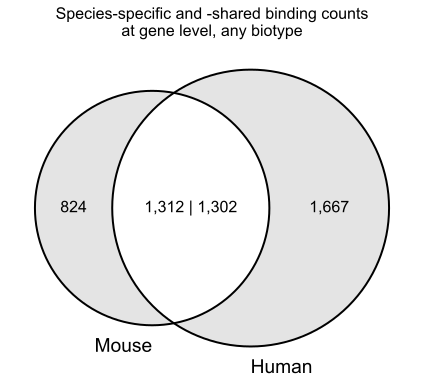

In [94]:
v = venn.venn2(
    subsets=(
        len(m_genes_no_bound_orth_complete),
        len(h_genes_no_bound_orth_complete),
        len(m_genes_bound_orth_complete),
    ),
    set_labels=("Mouse", "Human"),
    set_colors=(
        "#BBBBBB",
        "#BBBBBB",
    ),
)

# Update the labels to include the info on mouse | human orthologous bound genes.
v.subset_labels[0].set_text(f"{len(m_genes_no_bound_orth_complete):,}")
v.subset_labels[1].set_text(f"{len(h_genes_no_bound_orth_complete):,}")
v.subset_labels[2].set_text(f"{len(m_genes_bound_orth_complete):,} | {len(h_genes_bound_orth_complete):,}")

circles = venn.venn2_circles(
    subsets=(
        len(m_genes_no_bound_orth_complete),
        len(h_genes_no_bound_orth_complete),
        len(m_genes_bound_orth_complete),
    ),
    linestyle="-",
)

plt.title("Species-specific and -shared binding counts\nat gene level, any biotype")

if params_export_flag:
    plt.savefig(outputdir / "venn_diagram_genes_w_peaks.any_biotype.svg")

plt.show()

## Orthologies - 3'UTR biotype only

### Gather tables


We can build tables from the previously established tables. 

We only have to restrict those to the 3'UTR peaks in each species.

Then we re-establish the lists of genes.

In [ ]:
m_full_3utr = m_full.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
m_id_to_bed6_3utr = m_id_to_bed6.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
m_id_to_meta_3utr = m_id_to_meta.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
m_umap_3utr = m_umap.loc[lambda df: df["identifier"].isin(m_id_to_bed6_3utr.index.values), :].copy()
m_lift_3utr = m_lift.loc[lambda df: df["identifier.mouse_source"].isin(m_id_to_bed6_3utr.index.values), :].copy()


h_full_3utr = h_full.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
h_id_to_bed6_3utr = h_id_to_bed6.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
h_id_to_meta_3utr = h_id_to_meta.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
h_umap_3utr = h_umap.loc[lambda df: df["identifier"].isin(h_id_to_bed6_3utr.index.values), :].copy()
h_lift_3utr = h_lift.loc[lambda df: df["identifier.human_source"].isin(h_id_to_bed6_3utr.index.values), :].copy()

In [ ]:
h_bound_genes_3utr = set(h_id_to_meta_3utr.loc[h_umap_3utr["identifier"].values, "gene_id"].unique()) | set(
    h_id_to_meta_3utr.loc[h_lift_3utr["identifier.human_source"].values, "gene_id"].unique()
)
m_bound_genes_3utr = set(m_id_to_meta_3utr.loc[m_umap_3utr["identifier"].values, "gene_id"].unique()) | set(
    m_id_to_meta_3utr.loc[m_lift_3utr["identifier.mouse_source"].values, "gene_id"].unique()
)

m_lift_3utr["annotated_lifted_region_bound_gene_set"] = m_lift_3utr.apply(
    lambda row: (h_id_to_meta_3utr["gene_id_set"].get(row["identifier.human_target"], set({})) & h_bound_genes_3utr),
    axis=1,
)

h_lift_3utr["annotated_lifted_region_bound_gene_set"] = h_lift_3utr.apply(
    lambda row: (m_id_to_meta_3utr["gene_id_set"].get(row["identifier.mouse_target"], set({})) & m_bound_genes_3utr),
    axis=1,
)

### Gene counts - Mouse

#### First attempt

In [ ]:
m_has_gene_bound_orth_3utr = (
    (m_lift_3utr["gene_orthology_status"] != "not_orthologous")
    & (m_lift_3utr["annotated_lifted_region_bound_gene_set"].apply(len) > 0)
).values

###

m_peaks_w_bound_orth_3utr = m_lift_3utr.loc[m_has_gene_bound_orth_3utr, "identifier.mouse_source"].values
m_peaks_wo_bound_orth_3utr = m_lift_3utr.loc[~m_has_gene_bound_orth_3utr, "identifier.mouse_source"].values

###

m_genes_bound_orth_3utr = set(m_id_to_meta_3utr.loc[m_peaks_w_bound_orth_3utr, "gene_id"].unique())
m_genes_lifted_but_wo_annotated_bound_orth_3utr = set(
    m_id_to_meta_3utr.loc[m_peaks_wo_bound_orth_3utr, "gene_id"].unique()
)

###

# Here: aggregate the list of mouse ENS IDs identified as orthologs for the human peaks' annotated genes.
# i.e. : we know these genes mouse ENS-ID have a human ortholog that has a peak.
m_genes_from_human_peaks_w_orth_3utr = functools.reduce(
    set.union, h_lift_3utr["annotated_lifted_region_bound_gene_set"].values
)

###

m_genes_from_umap_3utr = set(m_id_to_meta_3utr.loc[m_umap_3utr["identifier"].values, "gene_id"].unique())

###

# Finally : build the list of genes without bound orthologous gene (i.e. mouse-specific bound genes)
# as the set of genes from unmappable peaks or peaks mapped but for which the lifted region is not an orthologous-bound gene.

m_genes_no_bound_orth_3utr = (
    (m_genes_from_umap_3utr | m_genes_lifted_but_wo_annotated_bound_orth_3utr)
    - m_genes_from_human_peaks_w_orth_3utr
    - m_genes_bound_orth_3utr
)

#### Missing genes

In [ ]:
m_missing_3utr = set(m_full_3utr["gene_id"].unique()) - m_genes_bound_orth_3utr - m_genes_no_bound_orth_3utr
print(len(m_missing))


m_peaks_in_missing_genes_3utr = m_full_3utr.loc[lambda df: df["gene_id"].isin(m_missing_3utr), :].assign(
    is_in_umap=lambda df: df["identifier"].isin(m_umap_3utr["identifier"].values)
)


display(m_peaks_in_missing_genes_3utr["is_in_umap"].value_counts())

# EXPECTED:
# True     68
# False    17

# So most peaks are not mapped,

# ALL THESE GENES ARE FOUND TO BE BOUND IN HUMAN PEAKS LIFTED TO MOUSE.
# i.e. I discard them wrongly in the last set operation, as they are bound in mouse but from unmapped peaks.

print(all([g in m_genes_from_human_peaks_w_orth_3utr for g in m_missing_3utr]))

# A subset of genes apparently are mappable, so I assume there it is a problem of gene annotation.


26


False    68
True     17
Name: is_in_umap, dtype: int64

True


#### Final numbers

In [100]:
m_genes_bound_orth_complete_3utr = m_genes_bound_orth_3utr | (
    set(m_peaks_in_missing_genes_3utr.loc[lambda df: df["is_in_umap"], "gene_id"].unique()) & m_bound_genes_3utr
)

m_genes_no_bound_orth_complete_3utr = m_genes_no_bound_orth_3utr | (
    set(m_peaks_in_missing_genes_3utr.loc[lambda df: (~df["is_in_umap"]), "gene_id"].unique()) & m_bound_genes_3utr
)
# Final correction on cases of n:n mappings : "bound" takes over "no-bound"
m_genes_no_bound_orth_complete_3utr = m_genes_no_bound_orth_complete_3utr - m_genes_bound_orth_complete_3utr

# FINAL TABLES

print(f"{len(m_genes_bound_orth_complete_3utr)=}")
print(f"{len(m_genes_no_bound_orth_complete_3utr)=}")
print(f"{(len(m_genes_bound_orth_complete_3utr) + len(m_genes_no_bound_orth_complete_3utr))=}")
print(f"{len(m_bound_genes_3utr)=}")
print(
    f"{(len(m_genes_bound_orth_complete_3utr) + len(m_genes_no_bound_orth_complete_3utr)) == len(m_bound_genes_3utr)=}"
)

len(m_genes_bound_orth_complete_3utr)=1015
len(m_genes_no_bound_orth_complete_3utr)=703
(len(m_genes_bound_orth_complete_3utr) + len(m_genes_no_bound_orth_complete_3utr))=1718
len(m_bound_genes_3utr)=1718
(len(m_genes_bound_orth_complete_3utr) + len(m_genes_no_bound_orth_complete_3utr)) == len(m_bound_genes_3utr)=True


### Gene counts - Human

#### First attempt

In [ ]:
h_has_gene_bound_orth_3utr = (
    (h_lift_3utr["gene_orthology_status"] != "not_orthologous")
    & (h_lift_3utr["annotated_lifted_region_bound_gene_set"].apply(len) > 0)
).values

###

h_peaks_w_bound_orth_3utr = h_lift_3utr.loc[h_has_gene_bound_orth_3utr, "identifier.human_source"].values
h_peaks_wo_bound_orth_3utr = h_lift_3utr.loc[~h_has_gene_bound_orth_3utr, "identifier.human_source"].values

###

h_genes_bound_orth_3utr = set(h_id_to_meta_3utr.loc[h_peaks_w_bound_orth_3utr, "gene_id"].unique())
h_genes_lifted_but_wo_annotated_bound_orth_3utr = set(
    h_id_to_meta_3utr.loc[h_peaks_wo_bound_orth_3utr, "gene_id"].unique()
)

###

# Here: aggregate the list of HUMAN ENS IDs identified as orthologs for the MOUSE peaks' annotated genes.
# i.e. : we know these genes HUMAN ENS-ID have a MOUSE ortholog that has a peak.
h_genes_from_mouse_peaks_w_orth_3utr = functools.reduce(
    set.union, h_lift_3utr["annotated_lifted_region_bound_gene_set"].values
)

###

h_genes_from_umap_3utr = set(h_id_to_meta_3utr.loc[h_umap_3utr["identifier"].values, "gene_id"].unique())

###

# Finally : build the list of genes without bound orthologous gene (i.e. HUMAN-specific bound genes)
# as the set of genes from unmappable peaks or peaks mapped but for which the lifted region is not an orthologous-bound gene.

h_genes_no_bound_orth_3utr = (
    (h_genes_from_umap_3utr | h_genes_lifted_but_wo_annotated_bound_orth_3utr)
    - h_genes_from_mouse_peaks_w_orth_3utr
    - h_genes_bound_orth_3utr
)

#### Missing genes

In [ ]:
h_missing_3utr = set(h_full_3utr["gene_id"].unique()) - h_genes_bound_orth_3utr - h_genes_no_bound_orth_3utr
print(f"Number of missing genes: {len(h_missing_3utr):,}")


h_peaks_in_missing_genes_3utr = h_full_3utr.loc[lambda df: df["gene_id"].isin(h_missing_3utr), :].assign(
    is_in_umap=lambda df: df["identifier"].isin(h_umap_3utr["identifier"].values)
)


display(h_peaks_in_missing_genes_3utr["is_in_umap"].value_counts())

# EXPECTED:
# None

# all genes should be covered

Number of missing genes: 0


Series([], Name: is_in_umap, dtype: int64)

#### Final numbers

In [ ]:
# Here in human : no missing genes, so we directly have access to the complete sets.

h_genes_bound_orth_complete_3utr = h_genes_bound_orth_3utr


h_genes_no_bound_orth_complete_3utr = h_genes_no_bound_orth_3utr


# FINAL TABLES

print(f"{len(h_genes_bound_orth_complete_3utr)=}")
(print(f"{len(h_genes_no_bound_orth_complete_3utr)=}"),)
print(f"{(len(h_genes_bound_orth_complete_3utr) + len(h_genes_no_bound_orth_complete_3utr))=}")
print(f"{len(h_bound_genes_3utr)}")
print(
    f"{(len(h_genes_bound_orth_complete_3utr) + len(h_genes_no_bound_orth_complete_3utr)) == len(h_bound_genes_3utr)=}"
)

len(h_genes_bound_orth_complete_3utr)=1000
len(h_genes_no_bound_orth_complete_3utr)=1480
(len(h_genes_bound_orth_complete_3utr) + len(h_genes_no_bound_orth_complete_3utr))=2480
2480
(len(h_genes_bound_orth_complete_3utr) + len(h_genes_no_bound_orth_complete_3utr)) == len(h_bound_genes_3utr)=True


### Plot

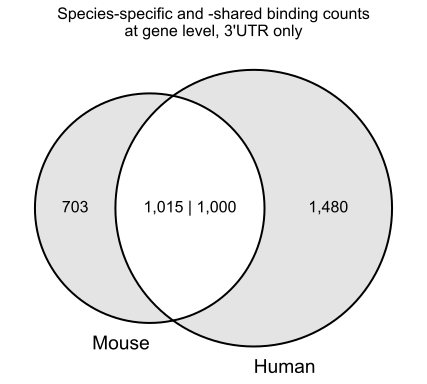

In [106]:
v = venn.venn2(
    subsets=(
        len(m_genes_no_bound_orth_complete_3utr),
        len(h_genes_no_bound_orth_complete_3utr),
        len(m_genes_bound_orth_complete_3utr),
    ),
    set_labels=("Mouse", "Human"),
    set_colors=(
        "#BBBBBB",
        "#BBBBBB",
    ),
)

# Update the labels to include the info on mouse | human orthologous bound genes.
v.subset_labels[0].set_text(f"{len(m_genes_no_bound_orth_complete_3utr):,}")
v.subset_labels[1].set_text(f"{len(h_genes_no_bound_orth_complete_3utr):,}")
v.subset_labels[2].set_text(f"{len(m_genes_bound_orth_complete_3utr):,} | {len(h_genes_bound_orth_complete_3utr):,}")

circles = venn.venn2_circles(
    subsets=(
        len(m_genes_no_bound_orth_complete_3utr),
        len(h_genes_no_bound_orth_complete_3utr),
        len(m_genes_bound_orth_complete_3utr),
    ),
    linestyle="-",
)

plt.title("Species-specific and -shared binding counts\nat gene level, 3'UTR only")

if params_export_flag:
    plt.savefig(outputdir / "venn_diagram_genes_w_peaks.3UTR.svg")

plt.show()

## Export data

### Mouse

In [131]:
print(f"{m_lift_3utr.shape=}")
display(m_lift_3utr.head(3))


if params_export_flag:
    fp = outputdir / "m_lift_3utr.tsv.gz"
    m_lift_3utr.to_csv(fp, sep="\t", index=False, compression="gzip")
    print("Wrote mouse 3'UTR with identified gene sets orthologies: ", fp)


m_lift_3utr.shape=(11880, 9)


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
0,chr1:6274997-6275006:+,chr8:52623049-52623059:-,True,True,"[(ENSMUSG00000025907, [ENSG00000023287])]",True,first,{ENSG00000023287},{}
1,chr1:7170406-7170415:+,chr8:51819766-51819775:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}
2,chr1:7170431-7170440:+,chr8:51819741-51819750:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}


Wrote mouse 3'UTR with identified gene sets orthologies:  ../results/gene_sets_overlaps/m_lift_3utr.tsv.gz


In [ ]:
print(f"{m_umap_3utr.shape=}")
m_umap_3utr.head(3)

if params_export_flag:
    fp = outputdir / "m_umap_3utr.tsv.gz"
    m_umap_3utr.to_csv(fp, sep="\t", index=False, compression="gzip")
    print("Wrote mouse 3'UTR unmapped peaks: ", fp)


m_umap_3utr.shape=(685, 3)
Wrote mouse 3'UTR unmapped peaks:  ../results/gene_sets_overlaps/m_umap_3utr.tsv.gz


In [214]:
# GENE SETS

print(f"{len(m_genes_bound_orth_complete)=}")
print(list(m_genes_bound_orth_complete)[:3])

if params_export_flag:
    fp = outputdir / "m_genes_bound_orth_complete.txt"
    with open(fp, "w") as f:
        f.write("\n".join(m_genes_bound_orth_complete) + "\n")


print(f"{len(m_genes_no_bound_orth_complete)=}")
print(list(m_genes_no_bound_orth_complete)[:3])

if params_export_flag:
    fp = outputdir / "m_genes_no_bound_orth_complete.txt"
    with open(fp, "w") as f:
        f.write("\n".join(m_genes_no_bound_orth_complete) + "\n")


###


print(f"{len(m_genes_bound_orth_complete_3utr)=}")
print(list(m_genes_bound_orth_complete_3utr)[:3])

if params_export_flag:
    fp = outputdir / "m_genes_bound_orth_complete_3utr.txt"
    with open(fp, "w") as f:
        f.write("\n".join(m_genes_bound_orth_complete_3utr) + "\n")


print(f"{len(m_genes_no_bound_orth_complete_3utr)=}")
print(list(m_genes_no_bound_orth_complete_3utr)[:3])

if params_export_flag:
    fp = outputdir / "m_genes_no_bound_orth_complete_3utr.txt"
    with open(fp, "w") as f:
        f.write("\n".join(m_genes_no_bound_orth_complete_3utr) + "\n")

len(m_genes_bound_orth_complete)=1312
['ENSMUSG00000018143', 'ENSMUSG00000035021', 'ENSMUSG00000079509']
len(m_genes_no_bound_orth_complete)=824
['ENSMUSG00000037958', 'ENSMUSG00000027177', 'ENSMUSG00000062949']
len(m_genes_bound_orth_complete_3utr)=1015
['ENSMUSG00000018143', 'ENSMUSG00000031924', 'ENSMUSG00000035021']
len(m_genes_no_bound_orth_complete_3utr)=703
['ENSMUSG00000037958', 'ENSMUSG00000027177', 'ENSMUSG00000062949']


In [208]:
display(m_id_to_meta.head(3))
print(f"{m_id_to_meta.shape=}")

if params_export_flag:
    fp = outputdir / "m_id_to_meta.tsv.gz"
    m_id_to_meta.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote mouse all metadata: ", fp)


display(m_id_to_meta_3utr.head(3))
print(f"{m_id_to_meta_3utr.shape=}")

if params_export_flag:
    fp = outputdir / "m_id_to_meta_3utr.tsv.gz"
    m_id_to_meta_3utr.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote mouse 3'UTR metadata: ", fp)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000025907}
chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}
chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}


m_id_to_meta.shape=(48126, 5)
Wrote mouse all metadata:  ../results/gene_sets_overlaps/m_id_to_meta.tsv.gz


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000025907}
chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}
chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000051285}


m_id_to_meta_3utr.shape=(30917, 5)
Wrote mouse 3'UTR metadata:  ../results/gene_sets_overlaps/m_id_to_meta_3utr.tsv.gz


In [203]:
print(f"{m_id_to_bed6_3utr.shape=}")
display(m_id_to_bed6_3utr.head(3))

if params_export_flag:
    fp = outputdir / "m_id_to_bed6_3utr.tsv.gz"
    m_id_to_bed6_3utr.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote mouse 3'UTR bed6: ", fp)

m_id_to_bed6_3utr.shape=(31695, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:6274997-6275006:+,chr1,6274997,6275006,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,9.344450,+
chr1:7170406-7170415:+,chr1,7170406,7170415,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,5.094060,+
chr1:7170431-7170440:+,chr1,7170431,7170440,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,26.054101,+


Wrote mouse 3'UTR bed6:  ../results/gene_sets_overlaps/m_id_to_bed6_3utr.tsv.gz


In [206]:
print(f"{m_id_to_bed6.shape=}")
display(m_id_to_bed6.head(3))

if params_export_flag:
    fp = outputdir / "m_id_to_bed6.tsv.gz"
    m_id_to_bed6.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote human 3'UTR bed6: ", fp)

m_id_to_bed6.shape=(49141, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:6274997-6275006:+,chr1,6274997,6275006,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,9.344450,+
chr1:7170406-7170415:+,chr1,7170406,7170415,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,5.094060,+
chr1:7170431-7170440:+,chr1,7170431,7170440,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,26.054101,+


Wrote human 3'UTR bed6:  ../results/gene_sets_overlaps/m_id_to_bed6.tsv.gz


### Human

In [178]:
print(f"{h_lift_3utr.shape=}")
display(h_lift_3utr.head(3))


if params_export_flag:
    fp = outputdir / "h_lift_3utr.tsv.gz"
    h_lift_3utr.to_csv(fp, sep="\t", index=False, compression="gzip")
    print("Wrote human 3'UTR with identified gene sets orthologies: ", fp)


h_lift_3utr.shape=(20706, 9)


,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
0,chr1:1211398-1211407:-,chr4:156016532-156016539:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}
1,chr1:1211415-1211424:-,chr4:156016517-156016524:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}
2,chr1:1211431-1211440:-,chr4:156016501-156016510:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}


Wrote human 3'UTR with identified gene sets orthologies:  ../results/gene_sets_overlaps/h_lift_3utr.tsv.gz


In [179]:
print(f"{h_umap_3utr.shape=}")
h_umap_3utr.head(3)

if params_export_flag:
    fp = outputdir / "h_umap_3utr.tsv.gz"
    h_umap_3utr.to_csv(fp, sep="\t", index=False, compression="gzip")
    print("Wrote mouse 3'UTR unmapped peaks: ", fp)


h_umap_3utr.shape=(1632, 3)
Wrote mouse 3'UTR unmapped peaks:  ../results/gene_sets_overlaps/h_umap_3utr.tsv.gz


In [212]:
# GENE SETS

print(f"{len(h_genes_bound_orth_complete)=}")
print(list(h_genes_bound_orth_complete)[:3])

if params_export_flag:
    fp = outputdir / "h_genes_bound_orth_complete.txt"
    with open(fp, "w") as f:
        f.write("\n".join(h_genes_bound_orth_complete) + "\n")


print(f"{len(h_genes_no_bound_orth_complete)=}")
print(list(h_genes_no_bound_orth_complete)[:3])

if params_export_flag:
    fp = outputdir / "h_genes_no_bound_orth_complete.txt"
    with open(fp, "w") as f:
        f.write("\n".join(h_genes_no_bound_orth_complete) + "\n")


###

print(f"{len(h_genes_bound_orth_complete_3utr)=}")
print(list(h_genes_bound_orth_complete_3utr)[:3])

if params_export_flag:
    fp = outputdir / "h_genes_bound_orth_complete_3utr.txt"
    with open(fp, "w") as f:
        f.write("\n".join(h_genes_bound_orth_complete_3utr) + "\n")


print(f"{len(h_genes_no_bound_orth_complete_3utr)=}")
print(list(h_genes_no_bound_orth_complete_3utr)[:3])

if params_export_flag:
    fp = outputdir / "h_genes_no_bound_orth_complete_3utr.txt"
    with open(fp, "w") as f:
        f.write("\n".join(h_genes_no_bound_orth_complete_3utr) + "\n")


len(h_genes_bound_orth_complete)=1302
['ENSG00000188404', 'ENSG00000113384', 'ENSG00000130699']
len(h_genes_no_bound_orth_complete)=1667
['ENSG00000213741', 'ENSG00000146282', 'ENSG00000100567']
len(h_genes_bound_orth_complete_3utr)=1000
['ENSG00000137642', 'ENSG00000188404', 'ENSG00000113384']
len(h_genes_no_bound_orth_complete_3utr)=1480
['ENSG00000169813', 'ENSG00000213741', 'ENSG00000146282']


In [207]:
display(h_id_to_meta.head(3))
print(f"{h_id_to_meta.shape=}")

if params_export_flag:
    fp = outputdir / "h_id_to_meta.tsv.gz"
    h_id_to_meta.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote human all metadata: ", fp)


display(h_id_to_meta_3utr.head(3))
print(f"{h_id_to_meta_3utr.shape=}")

if params_export_flag:
    fp = outputdir / "h_id_to_meta_3utr.tsv.gz"
    h_id_to_meta_3utr.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote human 3'UTR metadata: ", fp)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}


h_id_to_meta.shape=(49904, 5)
Wrote human all metadata:  ../results/gene_sets_overlaps/h_id_to_meta.tsv.gz


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}
chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{three_prime_UTR},{ENSG00000186827}


h_id_to_meta_3utr.shape=(33847, 5)
Wrote human 3'UTR metadata:  ../results/gene_sets_overlaps/h_id_to_meta_3utr.tsv.gz


In [ ]:
print(f"{h_id_to_bed6_3utr.shape=}")
display(h_id_to_bed6_3utr.head(3))

if params_export_flag:
    fp = outputdir / "h_id_to_bed6_3utr.tsv.gz"
    h_id_to_bed6_3utr.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote human 3'UTR bed6: ", fp)

h_id_to_bed6_3utr.shape=(34652, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:1211398-1211407:-,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-
chr1:1211415-1211424:-,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-
chr1:1211431-1211440:-,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-


Wrote human 3'UTR bed6:  ../results/gene_sets_overlaps/h_id_to_bed6_3utr.tsv.gz


In [205]:
print(f"{h_id_to_bed6.shape=}")
display(h_id_to_bed6.head(3))

if params_export_flag:
    fp = outputdir / "h_id_to_bed6.tsv.gz"
    h_id_to_bed6.to_csv(fp, sep="\t", index=True, compression="gzip")
    print("Wrote human 3'UTR bed6: ", fp)

h_id_to_bed6.shape=(50917, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:1211398-1211407:-,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-
chr1:1211415-1211424:-,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-
chr1:1211431-1211440:-,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-


Wrote human 3'UTR bed6:  ../results/gene_sets_overlaps/h_id_to_bed6.tsv.gz
